**Install dependencies**

In [ ]:
# %%capture
# try:
#     import miniai
# except ImportError:
#     !git clone https://github.com/fastai/course22p2.git
#     !pip install -e ./course22p2

In [ ]:
# %%capture
# !pip install -U torch torchvision torchaudio
# !pip install -U pillow pandas gradio kaggle timm bitsandbytes
# !pip install -U cjm_pil_utils cjm_pytorch_utils cjm_kaggle_utils cjm_pandas_utils

In [ ]:
# !pip install -U --pre timm

**Import dependencies**

In [ ]:
from pathlib import Path
import hashlib
import json
import random
import multiprocessing
import math
import os
from functools import partial
from copy import copy

import gradio as gr
from PIL import Image
import numpy as np
import timm

import pandas as pd
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PyTorch dependencies
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torcheval.tools import get_module_summary

# Import fastai dependencies
import fastcore.all as fc
from miniai.datasets import DataLoaders
from miniai.conv import def_device
from miniai.learner import *
from miniai.activations import Hook
from miniai.accel import MixedPrecision, AccelerateCB

# Import utility functions
from cjm_kaggle_utils.core import save_kaggle_creds, dl_kaggle
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, iterate_modules, tensor_stats_df
from cjm_pandas_utils.core import markdown_to_pandas

In [ ]:
timm.__version__

'0.6.12'

**Enter Kaggle username and API token**

In [ ]:
username = ""
key = ""

**Save Kaggle credentials to file**

In [ ]:
save_kaggle_creds(username, key, overwrite=False)

Empty username.


**Define directory paths**

In [ ]:
# Define path to store datasets
dataset_dir = Path("/mnt/980_1TB_2/Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)
print(f"Dataset Directory: {dataset_dir}")

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)
print(f"Archive Directory: {archive_dir}")

Dataset Directory: /mnt/980_1TB_2/Datasets
Archive Directory: /mnt/980_1TB_2/Datasets/../Archive


**Define Kaggle dataset**

In [ ]:
# Set the name of the dataset
dataset_name = 'pexels-110k-512p-min-jpg'
# dataset_name = 'pexels-110k-768p-min-jpg'

# Construct the Kaggle dataset name by combining the username and dataset name
kaggle_dataset = f'innominate817/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')
print(f"Archive Path: {archive_path}")

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')
print(f"Dataset Path: {dataset_path}")

Archive Path: /mnt/980_1TB_2/Datasets/../Archive/pexels-110k-512p-min-jpg.zip
Dataset Path: /mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg


**Download Kaggle dataset**

In [ ]:
dl_kaggle(kaggle_dataset, archive_dir, dataset_path)

Dataset already downloaded


**Define path to image folder**

In [ ]:
src_img_dir = Path(dataset_path/"images")
src_img_dir

Path('/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images')

**Get source images**

In [ ]:
# Get a list of the paths to the images in the images directory
src_img_paths = get_img_files(src_img_dir)

# Print the number of images in the images directory
print(len(src_img_paths))

109971


**Map image IDs to file paths**

In [ ]:
# Create a dictionary mapping image IDs to image paths
src_img_path_dict = {path.stem.split('-')[-1] : path for path in src_img_paths}

# Display the first few entries in the dictionary using a Pandas Dataframe
pd.DataFrame.from_dict(src_img_path_dict, orient='index').head()

0
1784798        /mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images/aerial-shot-bird-s-eye-view-court-1784798.jpg
2106673          /mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images/attractive-bangladesh-beautiful-2106673.jpg
1061142                         /mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images/1-art-background-1061142.jpg
2586334  /mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images/1-person-beauty-face-blurred-background-2586334.jpg
1460032                     /mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images/1-wtc-artist-concert-1460032.jpg

**Store list of image IDs**

In [ ]:
img_ids = list(src_img_path_dict.keys())
len(img_ids)

109971

**Select a subset of image IDs for training**

In [ ]:
img_ids_subset = img_ids
# img_ids_subset = random.sample(img_ids, 1000)
len(img_ids_subset)

109971

**Display sample image**

ID: 1391499


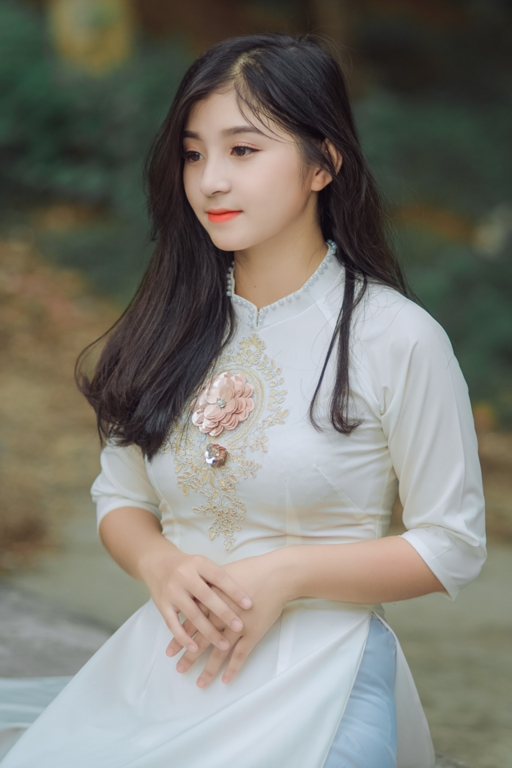

In [ ]:
# Choose a random image ID from the list of image IDs
img_id = random.choice(img_ids_subset)

img_id = '1391499'

print(f"ID: {img_id}")

# Open the image located at the path in the img_path_dict with the key of the current img_id
img_path = src_img_path_dict[img_id]
sample_img = Image.open(img_path)

# Display the image and its depth map
sample_img

**Define Kaggle style dataset**

In [ ]:
# Set the name of the dataset
style_dataset_name = 'style-image-samples'

# Construct the Kaggle dataset name by combining the username and dataset name
kaggle_style_dataset = f'innominate817/{style_dataset_name}'

# Create the path to the zip file that contains the dataset
style_archive_path = Path(f'{archive_dir}/{style_dataset_name}.zip')
print(f"Archive Path: {style_archive_path}")

# Create the path to the directory where the dataset will be extracted
style_dataset_path = Path(f'{dataset_dir}/{style_dataset_name}')
print(f"Dataset Path: {archive_dir}")

Archive Path: /mnt/980_1TB_2/Datasets/../Archive/style-image-samples.zip
Dataset Path: /mnt/980_1TB_2/Datasets/../Archive


**Download style dataset**

In [ ]:
dl_kaggle(kaggle_style_dataset, style_archive_path, style_dataset_path)

Dataset already downloaded


**Define path to style image folder**

In [ ]:
# Get a list of the paths to the images in the images directory
style_img_paths = get_img_files(style_dataset_path/"images")

# Print the number of images in the images directory
print(len(style_img_paths))

18


**Browse style images**

In [ ]:
# Current index
index = 0

# Function to go to the previous image
def prev_image():
    global index
    index = index - 1 if index > 0 else len(style_img_paths)-1
    return Image.open(style_img_paths[index])

# Function to go to the next image
def next_image():
    global index
    index = index + 1 if index < len(style_img_paths)-1 else 0
    return Image.open(style_img_paths[index])

with gr.Blocks() as demo:
    with gr.Row():
        prev_button = gr.Button('Previous')
        next_button = gr.Button('Next')
    image_output = gr.Image(Image.open(style_img_paths[index]))

    prev_button.click(prev_image, outputs=[image_output])
    next_button.click(next_image, outputs=[image_output])
        
demo.launch(height=1000)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


**Display selected style index**

In [ ]:
index = 4
index

4

**Get the path for the selected style image**

In [ ]:
style_img_path = style_img_paths[index]
style_img_path

Path('/mnt/980_1TB_2/Datasets/style-image-samples/images/mosaic.jpg')

**Load the selected style image**

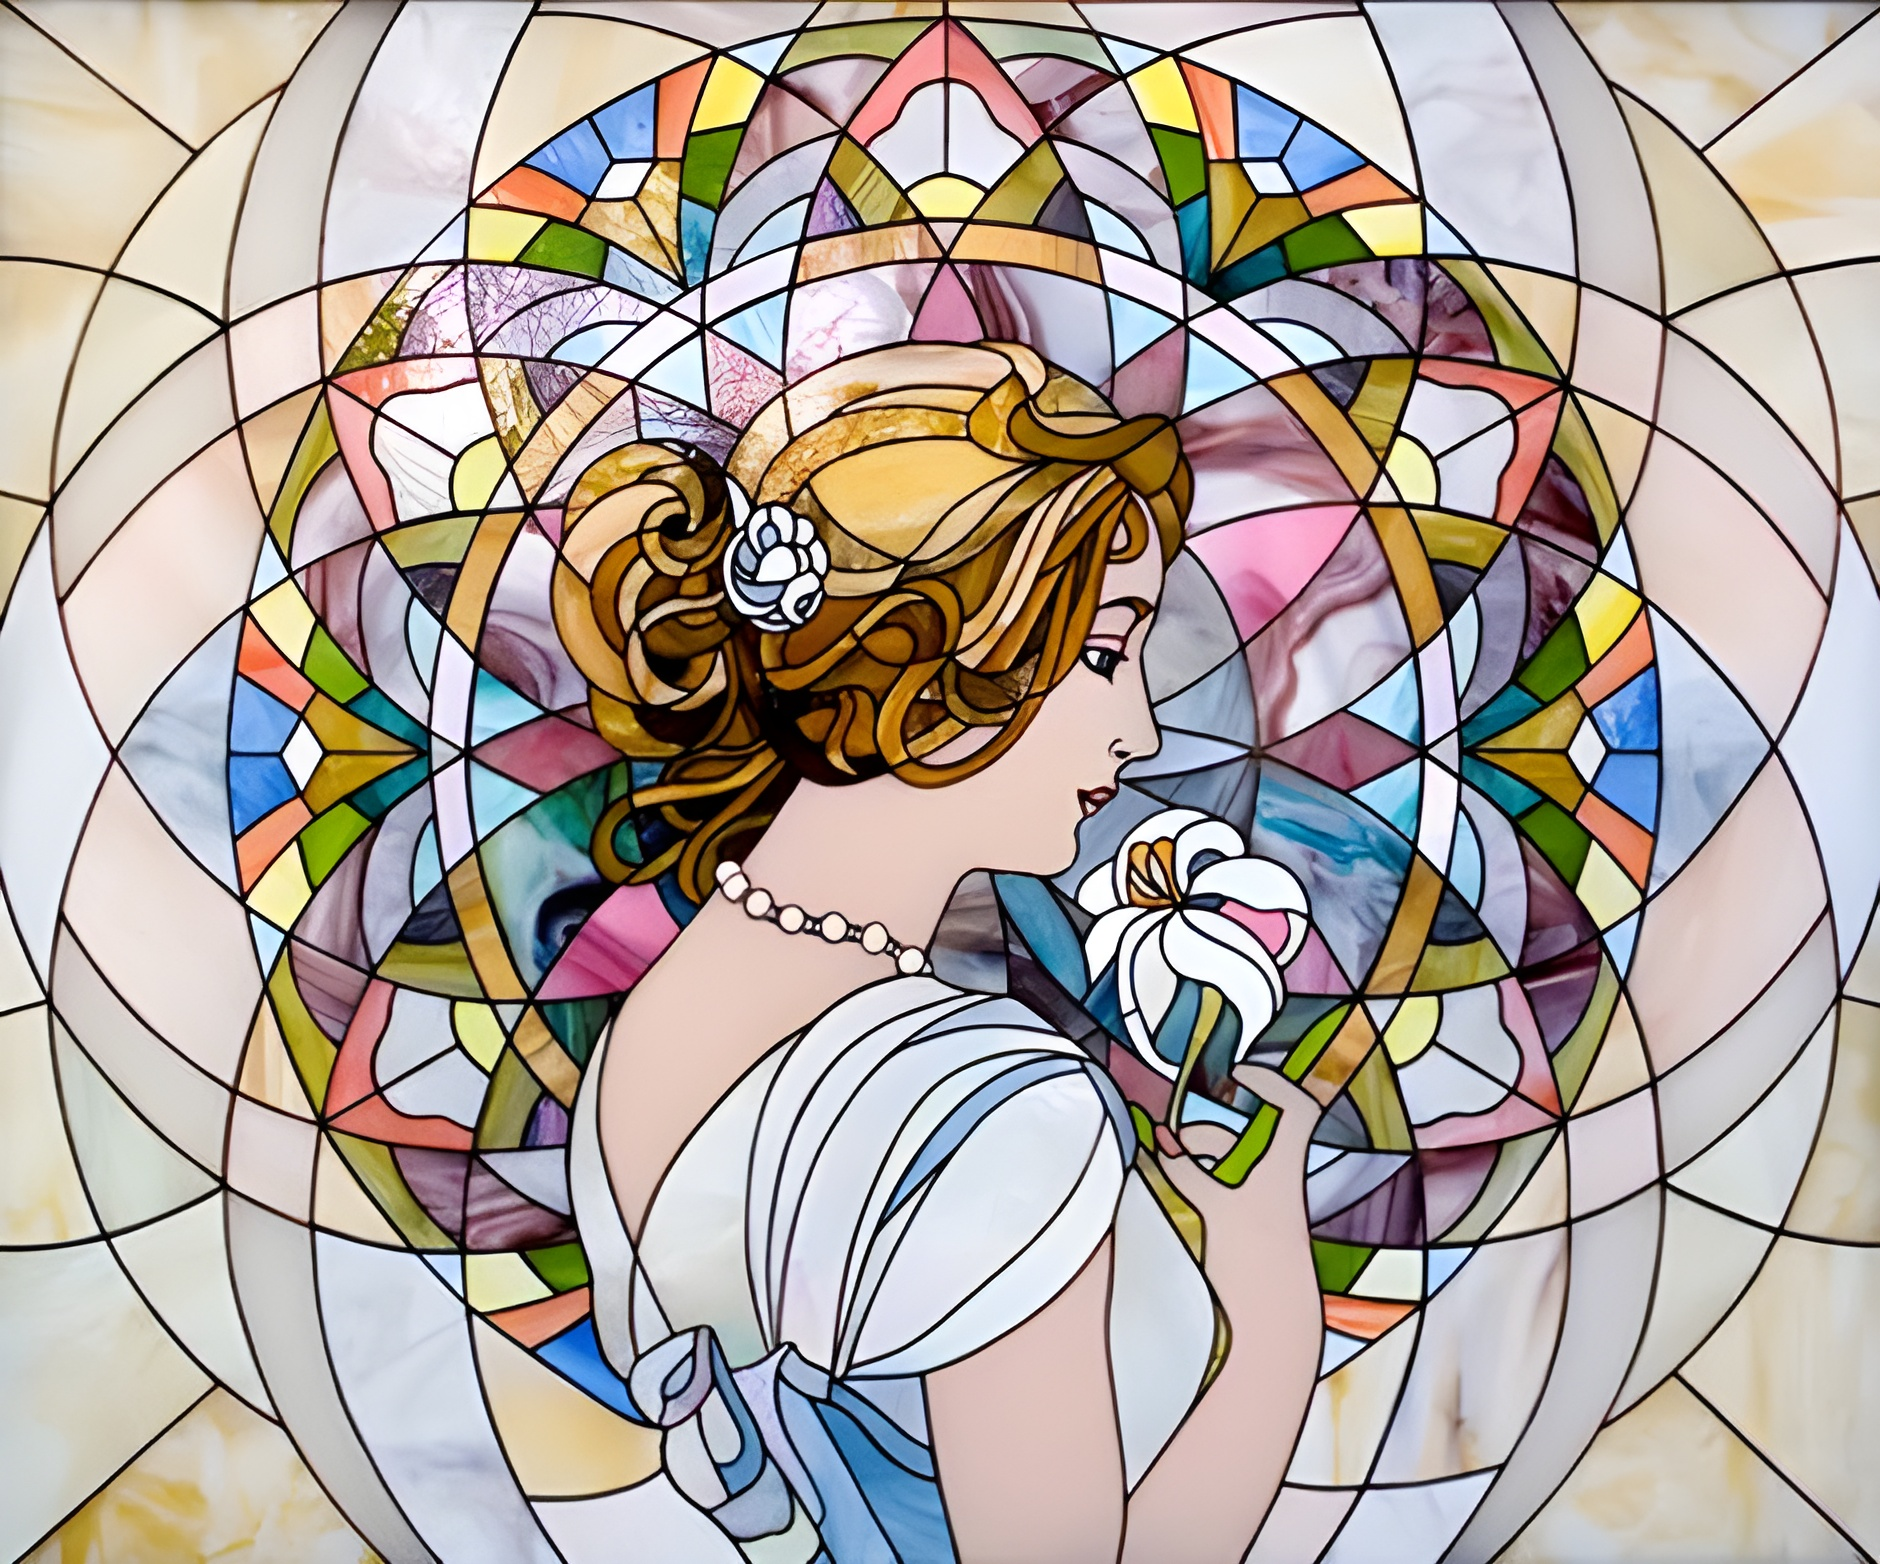

In [ ]:
style_img = Image.open(style_img_path).convert("RGB")
style_img

**Select PyTorch compute device**

In [ ]:
device = def_device
device

'cuda'

**Define model data type**

In [ ]:
train_dtype = torch.float32

**Define style transfer model normalization stats**

In [ ]:
# Normalize to the range [-0.5, 0.5]
norm_stats = [0.5], [1.0]

**Convert sample image to tensor**

In [ ]:
# Convert image to a normalized and batched tensor 
img_tensor = pil_to_tensor(sample_img, *norm_stats).to(device=device, dtype=train_dtype)
tensor_stats_df(img_tensor)

0
mean          -0.025289
std            0.247425
min           -0.472549
max                 0.5
shape  (1, 3, 768, 512)

**Define training dataset class**

In [ ]:
class StyleTransferDataset():
    """
    Dataset for style transfer.
    """
    def __init__(
        self,
        img_ids,
        src_img_path_dict,
        norm_stats,
        size=512,
        random_flip=False,
        center_crop=False,
    ):
        """
        Initialize the dataset.
        
        Parameters:
            img_ids (List): List of image IDs.
            src_img_path_dict (Dict): Dictionary of image IDs and corresponding image paths.
            norm_stats (Tuple): Mean and standard deviation for normalization.
            size (int, optional): Image size. Default: 512
            random_flip (bool, optional): Flag to random flip image. Default: False
            center_crop (bool, optional): Flag to center crop image. Default: False
        """
        self.img_ids = img_ids
        self.src_img_path_dict = src_img_path_dict
        
        self.size = size
        self.center_crop = center_crop
        
        # Compose a list of image transforms
        self.tfms_list = [
            transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(*norm_stats)
        ]
        
        if random_flip:
            # Add random horizontal flip to the transforms list
            self.tfms_list.insert(1, transforms.RandomHorizontalFlip(p=0.5))
        
        # Compose the final image transforms
        self.image_transforms = transforms.Compose(self.tfms_list)
        
    def __len__(self):
        """
        Return the length of the dataset.
        """
        return len(self.img_ids)
    
    def __getitem__(self, index):
        """
        Get the item at the specified index.
        
        Parameters:
            index (int): Index of the item to retrieve.
        
        Returns:
            torch.Tensor: Transformed image tensor.
        """
        img_id = self.img_ids[index % len(self.img_ids)]
        
        example = {}
        
        src_img_path = self.src_img_path_dict[img_id]
        src_img = Image.open(src_img_path)
        
        return self.image_transforms(src_img)

**Define training batch size**

In [ ]:
bs = 4

**Initialize datasets**

In [ ]:
# train_sz = 296
# train_sz = 384
train_sz = 512
# train_sz = 768

train_dataset = StyleTransferDataset(
    img_ids=img_ids_subset[:-bs],
    src_img_path_dict=src_img_path_dict,
    norm_stats=norm_stats,
    size=train_sz,
    random_flip=True,
    center_crop=False,
)

valid_dataset = copy(train_dataset)
valid_dataset.img_ids = img_ids_subset[-bs:]

len(train_dataset.img_ids), len(valid_dataset.img_ids)

(109967, 4)

**Inspect dataset sample**

In [ ]:
tensor_stats_df(train_dataset[0])

0
mean       -0.029235
std          0.29376
min             -0.5
max              0.5
shape  (3, 512, 512)

**Initialize dataloaders**

In [ ]:
# Initializing the dataloader for train dataset
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=bs, 
                                               shuffle=True, 
                                               num_workers=multiprocessing.cpu_count(), 
                                               pin_memory=True)

# Initializing the dataloader for the validation dataset
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=bs)

# Creating a DataLoaders object from the train and validation dataloaders
dls = DataLoaders(train_dataloader, valid_dataloader)

# Print the number of batches in the training and validation dataloaders
len(dls.train), len(dls.valid)

(27492, 1)

**Define style transfer model**

In [ ]:
class ConvLayer(nn.Module):
    """
    Applies reflection padding followed by a 2D convolution operation.
    
    Parameters:
    in_channels (int): The number of input channels for the 2D convolution operation.
    out_channels (int): The number of output channels for the 2D convolution operation.
    kernel_size (int): The size of the convolution kernel.
    stride (int): The stride of the convolution operation.
    """
    def __init__(self, in_channels:int, out_channels:int, kernel_size:int, stride:int):
        super(ConvLayer, self).__init__()
        
        self.conv = nn.Sequential(nn.ReflectionPad2d(kernel_size // 2), 
                                  nn.Conv2d(in_channels, out_channels, kernel_size, stride))
    def forward(self, x):
        return self.conv(x)
    
class ResBlock(nn.Module):
    """
    A residual block that consists of two convolutional layers followed by instance normalization,
    and an activation function, with the output of the block being added to the input.
    
    Parameters:
    channels (int): The number of channels in the input tensor.
    act (nn.Module, optional): The activation function. Defaults to nn.ReLU.
    """
    def __init__(self, channels:int, act:nn.Module=nn.ReLU):
        super(ResBlock, self).__init__()
        self.convs = nn.Sequential(
            ConvLayer(channels, channels, kernel_size=3, stride=1),
            nn.InstanceNorm2d(channels, affine=True),
            act(),
            ConvLayer(channels, channels, kernel_size=3, stride=1),
            nn.InstanceNorm2d(channels, affine=True),
        )

    def forward(self, x):
        return self.convs(x) + x

class DownsampleShuffle(nn.Module):
    """
    Performs downsampling using a reverse PixelShuffle operation.
    
    Parameters:
    in_channels (int): The number of channels in the input tensor.
    out_channels (int): The number of channels in the output tensor.
    scale (int, optional): The scale factor used for shuffling. Defaults to 2.
    act (nn.Module, optional): The activation function. Defaults to nn.ReLU.
    """
    def __init__(self, in_channels:int, out_channels:int, scale:int=2, act:nn.Module=nn.ReLU):        
        super(DownsampleShuffle, self).__init__()
        
        self.downsample = nn.Sequential(nn.Conv2d(in_channels, out_channels//(scale**2), kernel_size=1, stride=1), 
                                        act(),
                                        nn.PixelUnshuffle(scale))
    def forward(self, x):
        return self.downsample(x)

class UpsampleShuffle(nn.Module):
    """
    Performs upsampling layer using a PixelShuffle operation.
    
    Parameters:
    in_channels (int): The number of channels in the input tensor.
    out_channels (int): The number of channels in the output tensor.
    scale (int, optional): The scale factor used for shuffling. Defaults to 2.
    act (nn.Module, optional): The activation function. Defaults to nn.ReLU.
    """
    def __init__(self, in_channels:int, out_channels:int, scale:int=2, act:nn.Module=nn.ReLU):
        super(UpsampleShuffle, self).__init__()
        
        self.upsample = nn.Sequential(nn.Conv2d(in_channels, out_channels*(scale**2), kernel_size=1, stride=1), 
                                      act(), 
                                      nn.PixelShuffle(scale))
    def forward(self, x):
        return self.upsample(x)

In [ ]:
class FastNeuralStyleNet(nn.Module):
    def __init__(self, chnls=[32,64,128], res_blocks=5, act=nn.ReLU):
        """
        Parameters:
        chnls (list, optional): List of channels. Default is [32, 64, 128].
        res_blocks (int, optional): Number of residual blocks. Default is 5.
        act (nn.Module, optional): Activation function. Default is nn.ReLU.
        """
        super(FastNeuralStyleNet, self).__init__()
        
        # Input layers
        self.inp_layers = nn.Sequential(ConvLayer(3, chnls[0], kernel_size=3, stride=1), 
                                        nn.InstanceNorm2d(chnls[0], affine=True), 
                                        act())
        
        # Downsampling
        self.downsample = nn.Sequential(*[nn.Sequential(DownsampleShuffle(chnls[i], chnls[i+1], scale=2), 
                                                        nn.InstanceNorm2d(chnls[i+1], affine=True),
                                                        act()) for i in range(len(chnls)-1)])
        # Residual Blocks
        self.res_blocks = nn.Sequential(*[ResBlock(chnls[-1]) for _ in range(res_blocks)])
        
        # Upsampling
        self.upsample = nn.Sequential(*[nn.Sequential(UpsampleShuffle(chnls[i]*2, chnls[i-1], scale=2), 
                                                      nn.InstanceNorm2d(chnls[i-1], affine=True), 
                                                      act()) for i in range(len(chnls)-1, 0, -1)])
        # Output layers
        self.out_layers = nn.Sequential(ConvLayer(chnls[0], 3, kernel_size=3, stride=1), 
                                        nn.Sigmoid())
        
    def forward(self, X):
        
        # Downsampling
        down_out = [self.inp_layers(X)]
        for i, downsample in enumerate(self.downsample):
            down_out.append(downsample(down_out[i]))
        down_out.reverse() 
        
        # Residual Blocks
        up_out = [self.res_blocks(down_out[0])]
        
        # Upsampling
        for i, upsample in enumerate(self.upsample):
            up_out.append(upsample(torch.cat([down_out[i], up_out[i]], dim=1)))
            
        return self.out_layers(up_out[-1])

**Instantiate style transfer model**

In [ ]:
chnls=[16,32,64]
style_transfer_model = FastNeuralStyleNet(chnls=chnls, res_blocks=5).to(device)

**Initialize model weights**

In [ ]:
layer_type = nn.modules.conv.Conv2d
# Find all Conv2d layers in the model
conv_list = [module for module in iterate_modules(style_transfer_model) if type(module) == layer_type]

res_blocks = []
for conv in conv_list:
    # Initialize the weights of all Conv2d layers
    nn.init.kaiming_normal_(conv.weight)
    # Find all Conv2d layers in the res_blocks
    if conv.in_channels == chnls[-1]:
        res_blocks.append(conv)
        
# Zero out the weights of every second Conv2d layer in res_blocks
for i, conv in enumerate(res_blocks[:-1]):
    if i%2 != 0:
        conv.weight.data.zero_()

# Zero out the weights of the last Conv2d layer
conv_list[-1].weight.data.zero_();

**Get model summary**

In [ ]:
# Define the input to the model
test_inp = torch.randn(1, 3, *[train_dataset.size]*2).to(device)

# Get a summary of the model as a Pandas DataFrame
summary_df = markdown_to_pandas(f"{get_module_summary(style_transfer_model, [test_inp])}")

# Filter the summary to only contain Conv2d layers and the model
summary_df = summary_df[(summary_df.index == 0) | (summary_df['Type'] == 'Conv2d')]

# Remove the column "Contains Uninitialized Parameters?"
summary_df.drop('Contains Uninitialized Parameters?', axis=1)

Type # Parameters # Trainable Parameters Size (bytes)  \
0    FastNeuralStyleNet        393 K                  393 K        1.6 M   
5                Conv2d          448                    448        1.8 K   
12               Conv2d          136                    136          544   
20               Conv2d          528                    528        2.1 K   
31               Conv2d       36.9 K                 36.9 K        147 K   
37               Conv2d       36.9 K                 36.9 K        147 K   
44               Conv2d       36.9 K                 36.9 K        147 K   
50               Conv2d       36.9 K                 36.9 K        147 K   
57               Conv2d       36.9 K                 36.9 K        147 K   
63               Conv2d       36.9 K                 36.9 K        147 K   
70               Conv2d       36.9 K                 36.9 K        147 K   
76               Conv2d       36.9 K                 36.9 K        147 K   
83               Conv2d       36.9 K                 36.9 K        147 K   
89               Conv2d       36.9 K                 36.9 K        147 K   
95               Conv2d       16.5 K                 16.5 K       66.0 K   
103              Conv2d        4.2 K                  4.2 K       16.6 K   
112              Conv2d          435                    435        1.7 K   

    Forward FLOPs Backward FLOPs             In size            Out size  
0           6.9 G         13.6 G    [1, 3, 512, 512]    [1, 3, 512, 512]  
5           113 M          113 M    [1, 3, 514, 514]   [1, 16, 512, 512]  
12         33.6 M         67.1 M   [1, 16, 512, 512]    [1, 8, 512, 512]  
20         33.6 M         67.1 M   [1, 32, 256, 256]   [1, 16, 256, 256]  
31          603 M          1.2 G   [1, 64, 130, 130]   [1, 64, 128, 128]  
37          603 M          1.2 G   [1, 64, 130, 130]   [1, 64, 128, 128]  
44          603 M          1.2 G   [1, 64, 130, 130]   [1, 64, 128, 128]  
50          603 M          1.2 G   [1, 64, 130, 130]   [1, 64, 128, 128]  
57          603 M          1.2 G   [1, 64, 130, 130]   [1, 64, 128, 128]  
63          603 M          1.2 G   [1, 64, 130, 130]   [1, 64, 128, 128]  
70          603 M          1.2 G   [1, 64, 130, 130]   [1, 64, 128, 128]  
76          603 M          1.2 G   [1, 64, 130, 130]   [1, 64, 128, 128]  
83          603 M          1.2 G   [1, 64, 130, 130]   [1, 64, 128, 128]  
89          603 M          1.2 G   [1, 64, 130, 130]   [1, 64, 128, 128]  
95          268 M          536 M  [1, 128, 128, 128]  [1, 128, 128, 128]  
103         268 M          536 M   [1, 64, 256, 256]   [1, 64, 256, 256]  
112         113 M          226 M   [1, 16, 514, 514]    [1, 3, 512, 512]

**List available ConvNeXt Nano models**

In [ ]:
pd.DataFrame(timm.list_models('convnext_nano*', pretrained=True))

0
0      convnext_nano
1  convnext_nano_ols

**Inspect config for convnext model**

In [ ]:
# Import the convnext module
from timm.models import convnext

# Choose the convnext model
convnext_model = 'convnext_nano'

# Get the default configuration of the chosen model as a Pandas DataFrame
pd.DataFrame.from_dict(convnext.default_cfgs[convnext_model], orient='index')

0
url              https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/convnext_nano_d1h-7eb4bdea.pth
num_classes                                                                                                                     1000
input_size                                                                                                             (3, 224, 224)
pool_size                                                                                                                     (7, 7)
crop_pct                                                                                                                        0.95
interpolation                                                                                                                bicubic
mean                                                                                                           (0.485, 0.456, 0.406)
std                                                                                                            (0.229, 0.224, 0.225)
first_conv                                                                                                                    stem.0
classifier                                                                                                                   head.fc
test_input_size                                                                                                        (3, 288, 288)
test_crop_pct                                                                                                                    1.0

**Load `convnext_nano` model**

In [ ]:
# Load the convnext model
convnext = timm.create_model(convnext_model, pretrained=True).to(device)

# Set the device and data type
convnext = convnext.to(device=device, dtype=train_dtype).eval()
convnext.device = device

# Disable gradient calculation for the parameters
for param in convnext.parameters():
    param.requires_grad = False

**Select layers for perceptual loss**

In [ ]:
# Define the layer type to search for
layer_type = timm.models.layers.activations.GELU

# Get a list of modules in the perception model
modules_list = list(iterate_modules(convnext))

# Initialize an empty list to store the indices of modules of the desired type
convnext_feat_layers = []

# Loop through the modules in the list
for i, module in enumerate(modules_list):
    if type(module) == layer_type:
        convnext_feat_layers.append(i)
convnext_feat_layers

[13, 23, 38, 48, 63, 73, 83, 93, 103, 113, 123, 133, 148, 158]

**Load VGG model**

In [ ]:
# Load a VGG model
# vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features
vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features

# Set the device and data type
vgg = vgg.to(device=device, dtype=train_dtype).eval()
vgg.device = device

# Disable gradient calculation for the parameters
for param in vgg.parameters():
    param.requires_grad = False

**Select layers for perceptual loss**

In [ ]:
# Define the layer type to search for
layer_type = nn.modules.activation.ReLU
pool_type = nn.modules.pooling.MaxPool2d

# Get a list of modules in the perception model
modules_list = list(iterate_modules(vgg))

# Initialize an empty list to store the indices of modules of the desired type
vgg_feat_layers = []

# Loop through the modules in the list
for i, module in enumerate(modules_list):
    if type(module) == layer_type and type(modules_list[i+1]) == pool_type:
        vgg_feat_layers.append(i)
vgg_feat_layers

[3, 8, 17, 26, 35]

**Select perception model**

In [ ]:
perception_model = convnext
feat_layers = convnext_feat_layers

# perception_model = vgg
# feat_layers = vgg_feat_layers

**Define hook function to store module outputs**

In [ ]:
def hook_fn(hook, module, inp, out):
    # Store the output of the module
    hook.outputs = out

**Define callable loss class**

In [ ]:
class PerceptualStyleLoss():
    """
    Use a pre-trained perception model to extract features from the input tensors,
    and compares these features to calculate the content loss and style loss.
    """
    def __init__(self, 
                 perception_model:nn.Module, 
                 norm_stats:tuple, 
                 style_tensor:torch.Tensor, 
                 hook_fn, 
                 feat_layers:list,
                 content_wt:float=1e5, 
                 style_wt:float=1e10):
        """
        Parameters:
        perception_model: A pre-trained deep learning model to be used for extracting features.
        norm_stats: The normalization statistics for the input tensor.
        style_tensor: A tensor containing the style image.
        hook_fn: A function to store the output of the intermediate layers.
        feat_layers: List of layer indices to be used for feature extraction.
        content_wt: The weight for the content loss.
        style_wt: The weight for the style loss.
        """
        fc.store_attr()
        self.hooks = []
        self.hook_perception_model()
        self.gram_style = [self.gram_matrix(y) for y in self.get_features(style_tensor)]
        
    def hook_perception_model(self):
        """
        Attach hooks to the specified layers in the perception model.
        """
        modules_list = list(iterate_modules(self.perception_model))
        self.hooks = [Hook(modules_list[layer], self.hook_fn) for layer in self.feat_layers]
                
    def get_features(self, inp_tensor:torch.Tensor):
        """
        Extract features from the input tensor using the perception model.
        """
        if self.perception_model.device == 'cuda':
            with torch.cuda.amp.autocast():
                self.perception_model(inp_tensor)
        else:
            self.perception_model(inp_tensor)
        features = [hook.outputs.float() for hook in self.hooks]
        return features
    
    def gram_matrix(self, inp_tensor:torch.Tensor):
        """
        Calculate the gram matrix of the input tensor
        """
        (b, ch, h, w) = inp_tensor.size()
        features = inp_tensor.view(b, ch, w * h).float()
        gram = torch.einsum('bfs, bgs -> bfg', features, features) / (ch * h * w)
        return gram
    
    def __call__(self, x:torch.Tensor, y:torch.Tensor):
        """
        Calculate the content and style loss
        """
        features_y = self.get_features(transforms.Normalize(*self.norm_stats)(y))
        features_x = self.get_features(transforms.Normalize(*self.norm_stats)(x+0.5))
        
        content_loss = 0.
        for i, (ft_y, ft_x) in enumerate(zip(features_y, features_x)):
            content_loss += nn.functional.mse_loss(ft_y, ft_x)/(1/(len(features_x) - i))
        content_loss *= self.content_wt
        
        style_loss = 0.
        for i, (ft_y, gm_s) in enumerate(zip(features_y, self.gram_style)):
            gm_y = self.gram_matrix(ft_y)
            style_loss += nn.functional.mse_loss(gm_y, gm_s[:len(x), :, :])/(1/(i+1))
        style_loss *= self.style_wt
        
        return content_loss + style_loss

**Define perception model normalization stats**

In [ ]:
imagenet_stats = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

**Convert style image to tensor**

In [ ]:
style_tensor = pil_to_tensor(resize_img(style_img, train_dataset.size), *imagenet_stats)
# style_tensor = pil_to_tensor(resize_img(style_img, train_dataset.size, train_dataset.size), *imagenet_stats)
style_tensor = style_tensor.repeat(bs, 1, 1, 1).to(device=device, dtype=train_dtype)
tensor_stats_df(style_tensor)

0
mean           0.909291
std            1.230269
min           -2.117904
max                2.64
shape  (4, 3, 512, 608)

**Instantiate loss function**

In [ ]:
# # ConvNeXt
content_weight = 1e2
style_weight = 3e11

# VGG Weights
# content_weight = 1e5
# style_weight = 3e10

perceptual_style_loss = PerceptualStyleLoss(perception_model=perception_model, 
                                            norm_stats=imagenet_stats, 
                                            style_tensor=style_tensor, 
                                            hook_fn=hook_fn, 
                                            feat_layers=feat_layers,
                                            content_wt=content_weight, 
                                            style_wt=style_weight)

In [ ]:
class StyleOptCB(MixedPrecision):
    """
    A training callback that performs mixed precision training for the style transfer process.
    """

    def predict(self, learn):
        """
        Generate predictions for the current batch.
        """
        with torch.cuda.amp.autocast():
            learn.preds = learn.model(learn.batch)
        
    def get_loss(self, learn):
        """
        Exit the autocast context before computing the loss for the current batch.
        """
        self.autocast.__exit__(None, None, None)
        learn.loss = learn.loss_func(learn.batch, learn.preds)

In [ ]:
class StyleOptAccelerateCB(AccelerateCB):
    """
    A training callback that uses HuggingFace Accelerate for the style transfer process.
    """
    def predict(self, learn):
        """
        Generate predictions for the current batch.
        """
        learn.preds = learn.model(learn.batch)
        
    def get_loss(self, learn):
        """
        Compute the loss for the current batch.
        """
        learn.loss = learn.loss_func(learn.batch, learn.preds)

In [ ]:
class OutOfBoundsCB(Callback):
    """
    A callback that exits the training session if the loss is not NaN or infinite.
    """
    def __init__(self, msg="Loss out of bounds"):
        fc.store_attr()
        
    def after_loss(self, learn):
        """
        Check if the loss is NaN or infinite.
        """
        if learn.loss.detach().isnan() or learn.loss.detach().isinf(): 
            print(self.msg)
            raise CancelFitException()

In [ ]:
class ImageCheckpointCB(Callback):
    """
    A callback for saving images at intervals during training.
    
    Parameters:
    cp_int (int): Interval for saving checkpoint images.
    cp_path (str): Directory path to save checkpoint images.
    img_tensor (torch.Tensor): An image tensor to use as input to the model for checkpoint predictions.
    """
    def __init__(self, cp_int, cp_path, img_tensor):
        fc.store_attr()
        
    def after_loss(self, learn):
        if learn.iter != 0 and learn.iter%self.cp_int == 0:
            with torch.no_grad():
                pred = learn.model(img_tensor)
                
            # Convert the tensor to a PIL image
            test_img = tensor_to_pil(pred.squeeze())
            
            # Save the image to disk
            file_name = f"epoch-{learn.epoch}-batch-{learn.iter}.png"
            test_img.save(self.cp_path/file_name, fmt="PNG")

In [ ]:
class ModelCheckpointCB(Callback):
    """
    A callback to save model checkpoints at intervals during training.
    """
    def __init__(self, cp_int, cp_path):
        fc.store_attr()
        
    def after_loss(self, learn):
        if learn.iter != 0 and learn.iter%self.cp_int == 0:
            # Save the model's state dict to disk
            file_name = f"model-epoch-{learn.epoch}-batch-{learn.iter}.pth"
            torch.save(learn.model.state_dict(), Path(self.cp_path/file_name))

In [ ]:
# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path("./fns_checkpoints/")
checkpoint_dir.mkdir(parents=True, exist_ok=True)


# Create a name for the checkpoint based on the dataset and style image names and the training size
checkpoint_name = f"{dataset_path.stem.lower()}-{style_img_path.stem.lower()}-{train_sz}p"
checkpoint_path = Path(checkpoint_dir/f"{checkpoint_name}")
checkpoint_path.mkdir(parents=True, exist_ok=True)

# Define the path to save the trained model
model_path = Path(checkpoint_path/"model.pth")

# Print the checkpoint path
checkpoint_path

Path('fns_checkpoints/pexels-110k-512p-min-jpg-mosaic-512p')

**Select optimizer**

In [ ]:
# Use 8-bit Adam for lower memory usage when available
# https://github.com/TimDettmers/bitsandbytes
try:
    import bitsandbytes as bnb
    optimizer_class = bnb.optim.AdamW8bit
except ImportError:
    optimizer_class = torch.optim.AdamW
print(f"Optimizer Class: {optimizer_class.__name__}")

opt_func = partial(optimizer_class, eps=1e-2)

Optimizer Class: AdamW8bit


**Initialize checkpoint callbacks**

In [ ]:
checkpoint_interval = 500
img_checkpoint_cb = ImageCheckpointCB(checkpoint_interval, checkpoint_path, img_tensor)
model_checkpoint_cb = ModelCheckpointCB(checkpoint_interval, checkpoint_path)

In [ ]:
# Total number of training epochs
epochs = 1

# Max learning rate to use.
learning_rate = 2e-3

# Total number of training steps to perform.
max_train_steps = len(dls.train) * epochs

cbs = [StyleOptAccelerateCB(),
       OutOfBoundsCB(),
       DeviceCB(), 
       ProgressCB(plot=True),  
       img_checkpoint_cb, 
       model_checkpoint_cb]

learn = Learner(style_transfer_model, (dls), perceptual_style_loss, lr=learning_rate, cbs=cbs, opt_func=opt_func)

In [ ]:
learn.fit(epochs)

**Set inference data type**

In [ ]:
infer_dtype = torch.float16

**Set style transfer model to evaluation mode**

In [ ]:
style_transfer_model.to(device=device, dtype=infer_dtype);
style_transfer_model.eval();

**Set input size**

In [ ]:
infer_sz = 512

**Test style transfer model on sample images**

ID: 597039
New Dimensions: (768, 512)


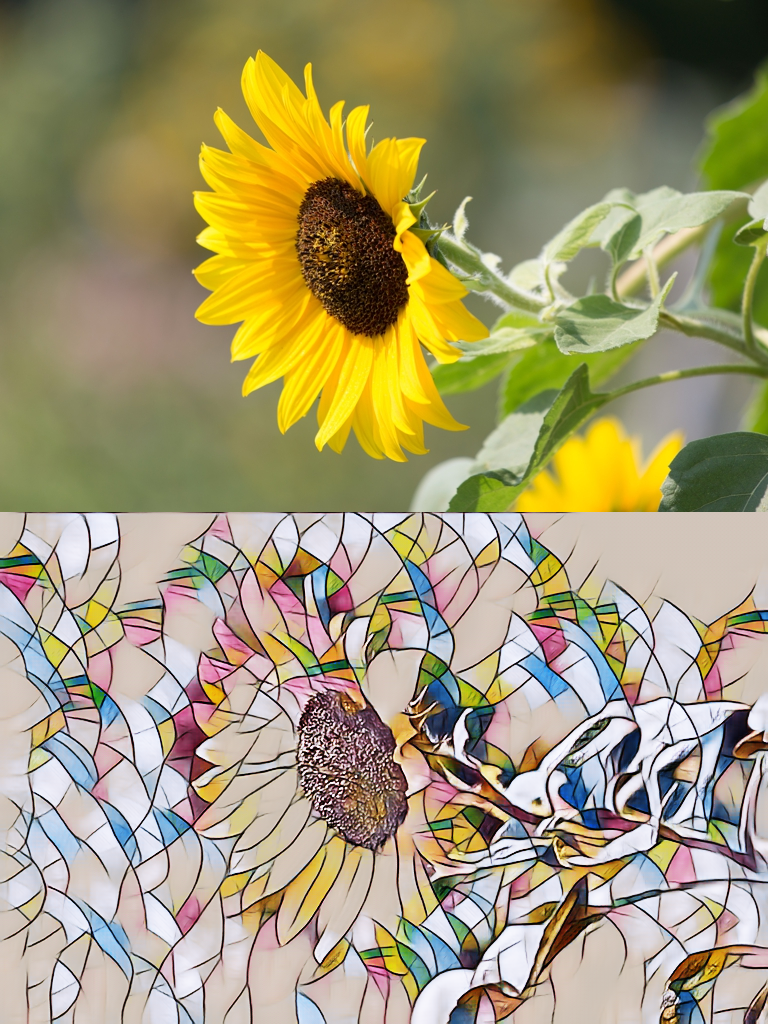

In [ ]:
# Choose a random image ID from the list of image IDs
img_id = random.choice(img_ids_subset)

img_id = "597039"

print(f"ID: {img_id}")

# Open the image located at the path in the img_path_dict with the key of the current img_id
img_path = src_img_path_dict[img_id]
sample_img = Image.open(img_path)

sample_img = resize_img(sample_img, target_sz=infer_sz, divisor=8)

# Print the dimensions of the resized image
print(f"New Dimensions: {sample_img.size}")

img_tensor = pil_to_tensor(sample_img, *norm_stats).to(device=device, dtype=infer_dtype)

with torch.no_grad():
    pred = style_transfer_model(img_tensor)
pred.shape

stylized_img = tensor_to_pil(pred.squeeze())

# Display the source image and stylized image
stack_imgs([sample_img, stylized_img])

**Set values for exporting the model to ONNX**

In [ ]:
opset_version = 11
export_dtype = train_dtype
export_dtype_str = f"{export_dtype}".split('.')[-1]

**Define save path for ONNX model**

In [ ]:
onnx_file_path = Path(checkpoint_path/f"model-opset-{opset_version}-{export_dtype_str}.onnx")
onnx_file_path

Path('fns_checkpoints/pexels-110k-512p-min-jpg-mosaic-512p/model-opset-11-float32.onnx')

**Export model to ONNX**

In [ ]:
torch.onnx.export(style_transfer_model.to(dtype=export_dtype),
                  img_tensor.to(dtype=export_dtype),
                  onnx_file_path,
                  export_params=True,
                  opset_version=opset_version,
                  do_constant_folding=False
                 )

/home/innom-dt/mambaforge/envs/sd-style-transfer/lib/python3.9/site-packages/torch/onnx/_internal/jit_utils.py:258: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/home/innom-dt/mambaforge/envs/sd-style-transfer/lib/python3.9/site-packages/torch/onnx/symbolic_helper.py:1457: UserWarning: ONNX export mode is set to TrainingMode.EVAL, but operator 'instance_norm' is set to train=True. Exporting with train=True.
  warnings.warn(
/home/innom-dt/mambaforge/envs/sd-style-transfer/lib/python3.9/site-packages/torch/onnx/utils.py:687: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_on